# Usage:

Note that if you want to train the CNN, GPU runtime is recommended.

In [7]:
# ! git clone https://github.com/google-research/slip
# %cd slip

from slip import experiment
from slip import models
from slip import potts_model
from slip import sampling
from slip import utils
from slip import tuning

import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from multiprocessing import Pool
from operator import itemgetter
import pandas as pd


ALL_AAS = 'ARNDCQEGHILKMFPSTWYV'

# Calculate measured protein parameters

In [16]:
import pandas as pd

# Import the combo TrpB_data
real_data = pd.read_csv('/home/zahra/Synthetic_Landscapes/Data/GB1/GB1_Fitness.csv').rename(columns={'Variants': 'AAs', 'Fitness': 'fitness'})
# Combine and sort the data
real_data = real_data.sort_values('AAs')

# Add a column where no fitness values are below 0
# wt = 'VFVS' # TrpB
wt = 'VDGV' # GB1
wt_fitness = real_data[real_data['AAs'] == wt]['fitness'].values[0]
real_data['centered_fitness'] = real_data['fitness'].apply(lambda x: np.log(x/wt_fitness))

real_fit_min = real_data['fitness'].min()

# add a column where sequences are stored as [0, 1, 2, 3] where numbers correspond to amino acid index in ALL_AAS
real_data['sequence'] = real_data['AAs'].apply(lambda x:[ALL_AAS.index(i) for i in x])

real_data

,AAs,HD,Count input,Count selected,fitness,centered_fitness,sequence
28187,AAAA,4,25,147,1.611610,0.477234,"[0, 0, 0, 0]"
28188,AAAG,4,13,5,0.105417,-2.249835,"[0, 0, 0, 7]"
28189,AAAH,4,15,0,0.000000,-inf,"[0, 0, 0, 8]"
28190,AAAI,4,10,0,0.000000,-inf,"[0, 0, 0, 9]"
28191,AAAL,4,43,15,0.095610,-2.347473,"[0, 0, 0, 10]"
...,...,...,...,...,...,...,...
149357,YYYS,4,186,3,0.004421,-5.421457,"[18, 18, 18, 15]"
149358,YYYT,4,181,14,0.021200,-3.853763,"[18, 18, 18, 16]"
28186,YYYV,3,98,15,0.041952,-3.171240,"[18, 18, 18, 19]"
149359,YYYW,4,30,1,0.009136,-4.695520,"[18, 18, 18, 17]"


In [17]:
# calc adaptive singles (SLIP) from real landscape data

def get_all_single_mutants(sequence, vocab_size):
    """Returns all single mutants of given `sequence`.

    For a given sequence, at each position there are `vocab_size` - 1 possible
    mutations.

    Args:
      sequence: A 1d vector of ints.
      vocab_size: The vocabulary size.

    Returns:
      A [(V-1)*L, L] numpy array of integer encoded sequences, where L is the
      length of the sequence and V is the vocab size.
    """
    sequence = np.array(sequence)
    seq_length = len(sequence)

    all_singles = []
    for pos in range(seq_length):
        num_singles = vocab_size - 1
        singles_at_pos = np.tile(sequence, (num_singles, 1))
        delta = np.arange(1, vocab_size, 1)
        singles_at_pos[:, pos] = (singles_at_pos[:, pos] + delta) % vocab_size
        all_singles.extend(singles_at_pos.tolist())
    return all_singles

def get_adaptive_single_fraction(real_landscape: pd.DataFrame, wt) -> float:
    """Returns the fraction of single mutants with fitness >= to the wildtype fitness."""
    wt_encoded = [ALL_AAS.index(x) for x in wt]
    all_singles = get_all_single_mutants(wt_encoded, 20)
    wt_fitness = real_landscape[real_landscape.AAs==wt]['centered_fitness'].item()
    mask = real_landscape.sequence.isin(all_singles)
    real_landscape = real_landscape[mask]
    fraction_adaptive = (real_landscape['centered_fitness'] >= wt_fitness).mean()
    return fraction_adaptive

In [18]:
# calculate epistasis stats (SLIP) from real landscape data
    # Not centered on wt fitness = 0 (SLIP does this)
def get_mutation_positions(sequence, parent):
    """Returns positions where sequence and parent disagree.

    Args:
      sequence: An int-encoded sequence.
      parent: An int-encoded sequence of the same length as `sequence`.

    Returns:
      np.ndarray int array of positions where `sequence` and `parent` disagree.
    """
    sequence = np.array(sequence)
    parent = np.array(parent)
    if len(sequence) != len(parent):
        raise AssertionError('Input sequences must have equal length '
                             '(%d vs. %d).' % (len(sequence), len(parent)))
    return np.where(sequence != parent)[0]

def get_doubles_df(real_landscape: pd.DataFrame, threshold: float, adaptive: bool, wt: str) -> pd.DataFrame:
    """Returns a DataFrame of all pairwise combinations of singles, where the singles are above/below a given fitness threshold.

    For each double mutant, the DataFrame includes the columns:
        'fitness': the fitness of the double.
        'a_fitness': the fitness of the first constituent single.
        'b_fitness': the fitness of the second constituent single.
        'residual': the epistatic term: fitness(ab) - fitness(a) - fitness(b) + fitness(wt).

    Args:
        landscape: The landscape on which to compute double fitness.
        threshold: The threshold fitness for filtering single mutants.
        adaptive: A boolean, indicating, if True (False), to construct pairwise combinations from single mutants
            that are above (below) the `threshold` fitness.

    Returns:
        A DataFrame of double mutants with keys 'fitness', 'a_fitness', 'b_fitness', and 'residual'.
    """
    wt_seq = [ALL_AAS.index(x) for x in wt]

    all_singles = get_all_single_mutants(wt_seq, 20)
    df = real_landscape[real_landscape.sequence.isin(all_singles)]
    if adaptive:
        singles = df[df.centered_fitness >= threshold].sequence
    else:
        singles = df[df.centered_fitness < threshold].sequence
    if len(singles) < 2:
        raise ValueError(f'Invalid Landscape: fewer than 2 singles for threshold {threshold}')
    doubles = []
    single_a = []
    single_b = []
    for a, b in itertools.combinations(singles, 2):
        # check that this is a true double
        if get_mutation_positions(a, wt_seq) == get_mutation_positions(b, wt_seq):
            continue
        double = utils.add_seqs(a, b, wt_seq)[0]
        doubles.append(double.tolist())
        single_a.append(a)
        single_b.append(b)
    doubles_df = real_landscape[real_landscape.sequence.isin(doubles)]
    single_a_df = pd.DataFrame({'sequence': [''.join([ALL_AAS[x] for x in s]) for s in single_a]})
    single_a_fitness = pd.merge(single_a_df, real_landscape[['AAs', 'centered_fitness']], left_on='sequence', right_on='AAs', how='inner')
    single_b_df = pd.DataFrame({'sequence': [''.join([ALL_AAS[x] for x in s]) for s in single_b]})
    single_b_fitness = pd.merge(single_b_df, real_landscape[['AAs', 'centered_fitness']], left_on='sequence', right_on='AAs', how='inner')
    doubles_df['a_fitness'] = single_a_fitness.centered_fitness.tolist()
    doubles_df['b_fitness'] = single_b_fitness.centered_fitness.tolist()
    residual = doubles_df.centered_fitness - doubles_df.a_fitness - doubles_df.b_fitness + real_landscape[real_landscape.AAs == wt].centered_fitness.item()
    doubles_df['residual'] = residual
    return doubles_df

def get_epistasis_stats(real_landscape: pd.DataFrame, doubles_df: pd.DataFrame, wt: str) -> [float, float]:
    """Returns statistics about epistasis for combinations of singles.

    Mean epistasis effect size is defined as the average effect of epistasis when two single mutants
    from the selected set are combined. The rate of reciprocal sign epistasis is defined as the fraction
    of epistatic interactions that have effects opposing the effects of the constituent singles. (e.g. the rate
    of negative epistasis for adaptive singles in combination).

    Args:
      landscape: The landscape.
      doubles_df: A DataFrame consisting of double mutants to compute epistasis statistic son.

    Returns:
        mean_epistasis_effect: The average effect of epistasis when two single mutants from the selected set are combined.
        rate_reciprocal_sign_epistasis: The fraction of epistatic interactions that have opposite effects to the constituent singles.
    """
    wt_encoded = [ALL_AAS.index(x) for x in wt]
    
    residual = get_doubles_df(real_landscape, threshold=0, adaptive= True).residual
    threshold = real_landscape[real_landscape.AAs == wt].centered_fitness.item()

    mean_epistasis_effect = np.mean(residual) # avg difference between double and single mutants
    if (doubles_df.a_fitness >= threshold).all() and (doubles_df.b_fitness >= threshold).all():
        adaptive = True
    elif (doubles_df.a_fitness < threshold).all() and (doubles_df.b_fitness < threshold).all():
        adaptive = False
    else:
        raise ValueError('Reciprocal sign epistasis undefined for inconsistent doubles effects.')

    if adaptive:
        rate_reciprocal_epistasis = (residual < 0).sum() / residual.shape[0]
    else:
        rate_reciprocal_epistasis = (residual > 0).sum() / residual.shape[0] # reciprocal sign epistasis (as defined by kadina)
    return mean_epistasis_effect, rate_reciprocal_epistasis

In [19]:
def get_mean_single_effect(real_landscape: pd.DataFrame, threshold: float, adaptive: bool, wt: str) -> float:
    """Returns average effect size of singles for a given threshold.

    Args:
      landscape: The landscape.
      threshold: The threshold fitness for singles.
      adaptive: If True, thresholded singles will have fitness >= `threshold`. If False,
        selected singles will have fitness < `threshold`.

    Returns:
      The average effect size of the selected singles.
    """
    wt_seq = [ALL_AAS.index(x) for x in wt]

    all_singles = get_all_single_mutants(wt_seq, 20)

    real_landscape = real_landscape[real_landscape.sequence.isin(all_singles)]

    if adaptive:
        mean_single_effect = real_landscape[real_landscape.centered_fitness >= threshold].centered_fitness.mean()
    else:
        mean_single_effect = real_landscape[real_landscape.centered_fitness < threshold].centered_fitness.mean()
    return mean_single_effect

def get_epistatic_horizon(real_landscape: pd.DataFrame, mean_single_effect) -> float:
    r"""Returns the epistatic horizon for the given landscape.

    The "epistatic horizon" is defined as the distance K from the wildtype at which, on average,
    epistatic contributions outweigh linear contributions from adaptive singles. This is interpreted as
    the average distance we can expect a greedy algorithm to perform well on the given landscape.

    Let s_+ be the average adaptive single mutant effect. let e_{+,+} be the average
    epistatic effect for a pair of adaptive singles. Then K is defined as :

    $$
    K * s_+ + (K \\choose 2) e_{+,+} = 0
    $$

    Solving for K:

    $$
    K = \\dfrac{e_{+,+} - 2 s_+}
               {e_{+,+}}
    $$

    Returns:
      The epistatic horizon.
    """
    doubles_df = get_doubles_df(real_landscape, threshold=0.0, adaptive=True)
    mean_adaptive_epistasis, _ = get_epistasis_stats(real_landscape, doubles_df)
    if mean_single_effect == 0.0:
        epistatic_horizon = np.inf
    else:
        epistatic_horizon = (mean_adaptive_epistasis - 2 * mean_single_effect) / mean_adaptive_epistasis
    return epistatic_horizon

# Load a landscape from an existing set of weights

In [34]:
## mogwai potts model
# location = '/home/zahra/useful_code_for_zahra/slip/mogwai/data/TrpB/'
# file = location + 'tm9d8s_b0.3_potts_state_dict_updated_200_epochs.npz'

# mutation predictability potts model
location = '/home/zahra/Synthetic_Landscapes/Data/1_potts_results/'
file = location + 'GB1/output.npz'

# wt = 'VFVS' # TrpB
wt = 'VDGV' # GB1

In [35]:
# Only need to run once
# # Update Potts Model output to only contain four sites of inteterest
# sites = [183, 184, 227, 228] # TrpB
sites = [39,40,41,54] # GB1
sites = [p-1 for p in sites] # subtract 1 for zero indexing, start w 397 rows don't subtract 3 for lowerecase letters

data = np.load(file, allow_pickle=True)

seq = [ALL_AAS.index(aa) for aa in wt]
bias = data['arr_0'][sites, :]
weights = data['arr_1']

# takes more effort to extract proper indices weights (otherwise 3rd col gets dropped)
temp = np.empty((4, 20, 4, 20))

for i, row_pos in enumerate(sites):
    for j, col_pos in enumerate(sites):
        temp[i, :, j, :] = weights[row_pos, :, col_pos, :]

weights = temp

# print(weights.shape) #--> (4, 20, 4, 20)
# print(bias.shape) # --> (4, 20)

f = np.savez(location + 'GB1_output_4site.npz', bias=bias, weight=weights, query_seq=seq)


Text(0.5, 0.98, 'Mutation Predictability Potts Model Bias')

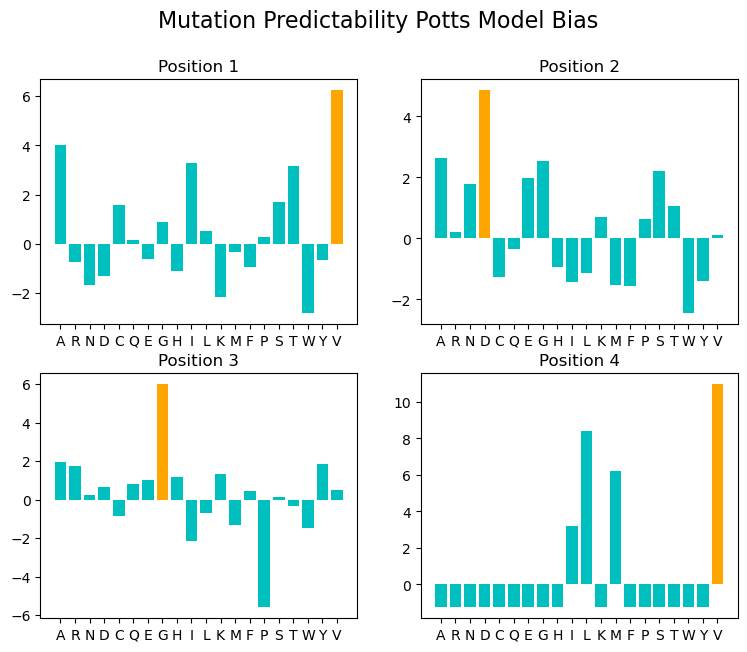

In [36]:
# checking for most conserved positions of 4 site landscape --> looks great

import matplotlib.pyplot as plt

positions = [0, 1, 2, 3]

plt.figure(figsize=(9,7))

consv = 'VDGV'

for p in positions:
    plt.subplot(2,2,p+1)
    for i in range(20):
        plt.bar(ALL_AAS[i], bias[p][i], color = 'c')
    wt_aa = ALL_AAS.find(wt[p])
    consv_aa = ALL_AAS.find(consv[p])
    plt.bar(wt[p], bias[p][wt_aa], color = 'olive')
    plt.bar(consv[p], bias[p][consv_aa], color = 'orange')
    plt.title('Position ' + str(p+1))
plt.suptitle('Mutation Predictability Potts Model Bias', fontsize=16)

In [37]:
# load landscape
# see slip.potts_model.PottsModel for tuning kwargs.

file = location + 'GB1_output_4site.npz'
landscape = potts_model.load_from_mogwai_npz(file, coupling_scale=1.0)
VOCAB_SIZE = 20

In [38]:
# whole landscape wildtype seq is correct (does not include lowercase letters) 

# 4 site landscape wildtype seq is correct (VFVS)
for p in landscape.wildtype_sequence:
    print(ALL_AAS[p])

V
D
G
V


In [39]:
# Untuned landscape stats
tuning.get_landscape_stats(landscape)

ValueError: Invalid Landscape: fewer than 2 singles for threshold 0.0

In [13]:
# Get real landscape stats
doubles_df = get_doubles_df(real_data, threshold=0, adaptive=True, wt=wt)
fraction_adaptive_singles = get_adaptive_single_fraction(real_data, wt)
epistasis_stats = get_epistasis_stats(real_data, doubles_df, wt)
mean_single_effect = get_mean_single_effect(real_data, threshold=0, adaptive=True, wt=wt)
epistatic_horizon = get_epistatic_horizon(real_data, mean_single_effect, wt=wt)

/tmp/ipykernel_91130/1588729758.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doubles_df['a_fitness'] = single_a_fitness.centered_fitness.tolist()
/tmp/ipykernel_91130/1588729758.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doubles_df['b_fitness'] = single_b_fitness.centered_fitness.tolist()
/tmp/ipykernel_91130/1588729758.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [14]:
print('fraction adaptive singles: ', fraction_adaptive_singles)
print('adaptive mean epistasis effect: ', epistasis_stats[0])
print('rate reciprocal sign epistasis: ', epistasis_stats[1])
print('mean single effect: ', mean_single_effect)
print('epistatic horizon: ', epistatic_horizon)

fraction adaptive singles:  0.11842105263157894
adaptive mean epistasis effect:  -0.3395829634742197
rate reciprocal sign epistasis:  0.8518518518518519
mean single effect:  0.20745920680352958
epistatic horizon:  2.2218469659434454


In [14]:
# Tune landscape
tuning_kwargs = tuning.get_tuning_kwargs(landscape, fraction_adaptive_singles= fraction_adaptive_singles, fraction_reciprocal_adaptive_epistasis=epistasis_stats[1], epistatic_horizon=epistatic_horizon)
# tuning_kwargs = tuning.get_tuning_kwargs(landscape, fraction_adaptive_singles= 0.9, fraction_reciprocal_adaptive_epistasis=0.9, epistatic_horizon=2)


tuned_landscape = potts_model.load_from_mogwai_npz(file, **tuning_kwargs)
print('\n Tuned landscape stats:')
tuning.get_landscape_stats(tuned_landscape)

Untuned landscape stats:
{'epistatic_horizon': -71.50406867090209,
 'fraction_adaptive_singles': 0.07894736842105263,
 'fraction_reciprocal_adaptive_epistasis': 0.25,
 'reciprocal_adaptive_epistasis_effect': 0.05316886923113392,
 'std_singles': 3.5412742369613714}

 Tuned landscape stats:


{'fraction_adaptive_singles': 0.8947368421052632,
 'reciprocal_adaptive_epistasis_effect': -11.054418511627569,
 'fraction_reciprocal_adaptive_epistasis': 0.8997101449275362,
 'epistatic_horizon': 1.9999875263598197,
 'std_singles': 3.541274379988924}

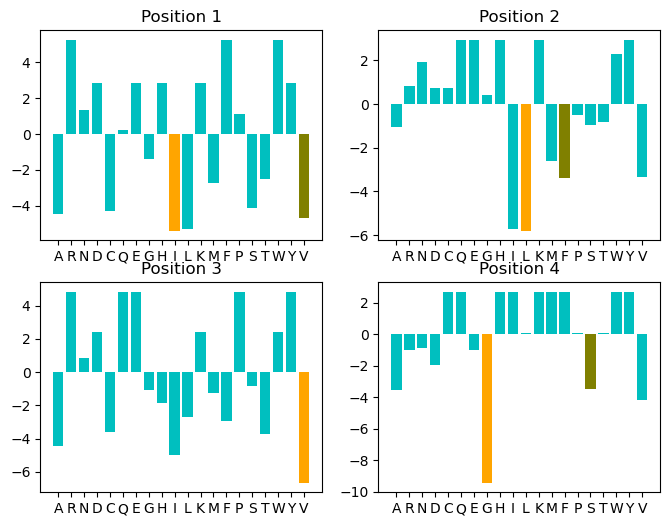

In [31]:
# positions = [0, 1, 2, 3]

# plt.figure(figsize=(8,6))

# wt = 'VFVS'
# consv = 'ILVG'

# for p in positions:
#     plt.subplot(2,2,p+1)
#     for i in range(20):
#         plt.bar(ALL_AAS[i], tuned_landscape.field_vec[p][i], color = 'c')
#     wt_aa = ALL_AAS.find(wt[p])
#     consv_aa = ALL_AAS.find(consv[p])
#     plt.bar(wt[p], tuned_landscape.field_vec[p][wt_aa], color = 'olive')
#     plt.bar(consv[p], tuned_landscape.field_vec[p][consv_aa], color = 'orange')
#     plt.title('Position ' + str(p+1))

In [26]:
def get_combos(sequence, vocab_size, sites):
    """Returns all single mutants of given `sequence`.

    For a given sequence, at each position there are `vocab_size` - 1 possible
    mutations.

    Args:
      sequence: A 1d vector of ints.
      vocab_size: The vocabulary size.

    Returns:
      A [(V-1)*L, L] numpy array of integer encoded sequences, where L is the
      length of the sequence and V is the vocab size.
    """
    sequence = np.array(sequence)
    seq_length = len(sequence)

    #substract the number of lower case letters at the beginning
    sites = [site - 3 - 1 for site in sites]

    #use itertools to get all combinations of mutations
    all_combos_tokens  = list(itertools.product(range(vocab_size), repeat=len(sites)))


    all_seqs = []
    for variant in all_combos_tokens:
        sequence = sequence.copy()
        for token, site in zip(variant, sites):
            sequence[site] = token
        all_seqs.append(sequence)

    return np.vstack(all_seqs)

In [16]:
#landscape = tuned_landscape
foursite = get_combos(tuned_landscape.wildtype_sequence, VOCAB_SIZE, [0, 1, 2, 3])

# assign AA for each variant
d = dict(enumerate(ALL_AAS))
foursite_AA = np.vectorize(d.get)(foursite)

In [17]:
# Rank fitness for different landscapes and export
import math

foursite = get_combos(tuned_landscape.wildtype_sequence, VOCAB_SIZE, [0, 1, 2, 3])

# assign AA for each variant
d = dict(enumerate(ALL_AAS))
foursite_AA = np.vectorize(d.get)(foursite)

df = experiment.get_fitness_df(foursite, tuned_landscape.evaluate, tuned_landscape.wildtype_sequence)
df['AAs'] = foursite_AA.tolist()
df['AAs'] = df['AAs'].apply(lambda x: ''.join(x))
df.set_index('AAs', inplace=True)
df = df.sort_values('fitness', ascending=False)

# add columns for AA at each position
for i in range(4):
    df.insert(i+1, f'AA{i+1}', df.index.to_series().apply(lambda x: x[i]))

df['active'] = df['fitness'] > 0

df.to_csv('/home/zahra/Synthetic_Landscapes/Data/112223_tuned_0.90.92_mut_pred_synthetic_landscape_TrpB.csv', index=True)

df


,sequence,AA1,AA2,AA3,AA4,num_mutations,fitness,active
AAs,,,,,,,,
LVVS,"[10, 19, 19, 15]",L,V,V,S,2,59.319327,True
MIVG,"[12, 9, 19, 7]",M,I,V,G,3,57.909255,True
LLVS,"[10, 10, 19, 15]",L,L,V,S,2,56.940079,True
CVIS,"[4, 19, 9, 15]",C,V,I,S,3,53.256630,True
LLTS,"[10, 10, 16, 15]",L,L,T,S,3,52.837866,True
...,...,...,...,...,...,...,...,...
IMQN,"[9, 12, 5, 2]",I,M,Q,N,4,-88.110298,False
IMAN,"[9, 12, 0, 2]",I,M,A,N,4,-88.342368,False
IMCN,"[9, 12, 4, 2]",I,M,C,N,4,-88.343526,False


Text(0.5, 0.98, 'AA Count for variants > WT \n tuned w real ep stats')

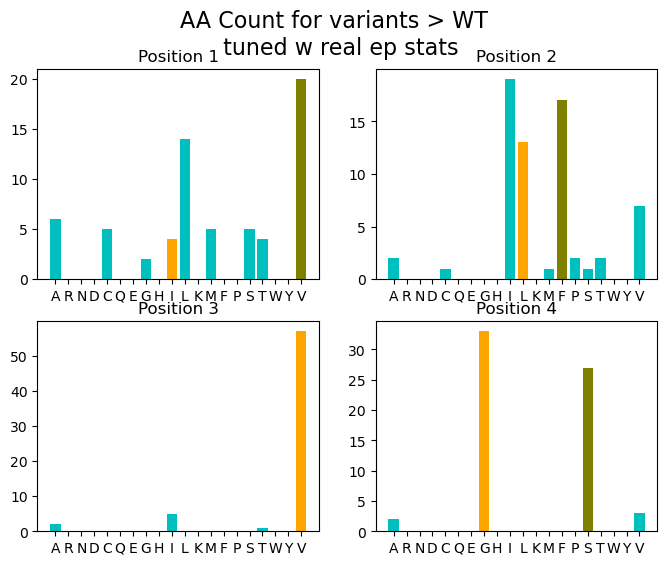

In [35]:
# plot # AA at each position
    # for variants with activity > wt (0)

plt.figure(figsize=(8,6))

active = df[df['active']]

wt = 'VFVS'
consv = 'ILVG'

for i in range(4):
    count_dict = dict(zip(ALL_AAS, [0]*20))
    for aa in ALL_AAS:
        count_dict[aa] = active['AA' + str(i+1)].str.count(aa).sum()
    plt.subplot(2,2,i+1)
    plt.bar(count_dict.keys(), count_dict.values(), color = 'c')
    plt.bar(wt[i], count_dict[wt[i]], color = 'olive')
    plt.bar(consv[i], count_dict[consv[i]], color = 'orange')
    plt.title('Position ' + str(i+1))

plt.suptitle('AA Count for variants > WT \n tuned w real ep stats', fontsize=16)

In [28]:
foursite = get_combos(landscape.wildtype_sequence, VOCAB_SIZE, [0, 1, 2, 3])
df = experiment.get_fitness_df(foursite, landscape.evaluate, wt)

In [33]:
df.sort_values('fitness', ascending=False)

for i in [19, 3, 7, 19]:
    print(ALL_AAS[i])

V
D
G
V


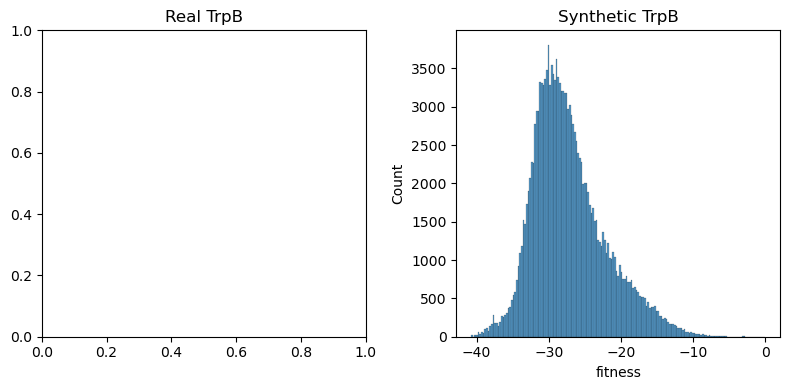

In [29]:
# plot synthetic and real fitness

f, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(data=real_data, x='centered_fitness', ax=axs[0])
sns.histplot(data=df, x='fitness', ax=axs[1])
axs[0].set_title('Real TrpB')
axs[1].set_title('Synthetic TrpB')
f.tight_layout()

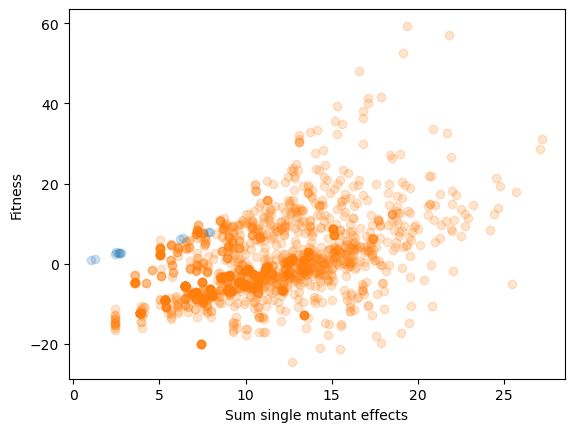

In [23]:
# plot tuned v untuned --> like SLIP figue 1

# calculate sum of single mutant effects
tuned_doubles_df = tuning.get_doubles_df(tuned_landscape, threshold=0, adaptive=True)
tuned_doubles_df['sum_singles'] = tuned_doubles_df['a_fitness'] + tuned_doubles_df['b_fitness']

doubles_df = tuning.get_doubles_df(landscape, threshold=0, adaptive=True)
doubles_df['sum_singles'] = doubles_df['a_fitness'] + doubles_df['b_fitness']

plt.scatter(doubles_df['sum_singles'], doubles_df['fitness'], alpha = 0.2, label = 'Untuned', zorder = 2)
plt.scatter(tuned_doubles_df['sum_singles'], tuned_doubles_df['fitness'], alpha = 0.2, label = 'Tuned', zorder = 1)

plt.xlabel('Sum single mutant effects')
plt.ylabel('Fitness')
plt.show()

# Sample a set of variants

In [ ]:
all_singles = sampling.get_all_single_mutants(landscape.wildtype_sequence, VOCAB_SIZE)
random_doubles = sampling.sample_within_hamming_radius(landscape.wildtype_sequence, 1000, VOCAB_SIZE, 2, 2)

In [ ]:
import pandas as pd

singles_df = experiment.get_fitness_df(all_singles, landscape.evaluate, landscape.wildtype_sequence)
singles_df['name'] = 'singles'
random_doubles_df = experiment.get_fitness_df(random_doubles, landscape.evaluate, landscape.wildtype_sequence)
random_doubles_df['name'] = 'random_doubles'

df = pd.concat([singles_df, random_doubles_df], ignore_index=True)


In [1]:
import seaborn as sns

sns.displot(data=df, x='fitness', hue='name')

NameError: name 'df' is not defined

# Take a random sample within distance 4

In [ ]:
sample = sampling.sample_within_hamming_radius(landscape.wildtype_sequence, 2000, VOCAB_SIZE, 0, 4)
df = experiment.get_fitness_df(sample, landscape.evaluate, landscape.wildtype_sequence)

train_df, test_df = experiment.get_distance_split_df(df, landscape.wildtype_sequence, 1)
train_df['name'] = 'train'
test_df['name'] = 'test'

df = pd.concat([train_df, test_df], ignore_index=True)
sns.lineplot(data=df, x='num_mutations', y='fitness', errorbar='sd', hue='name')

# Designing sequences with a model

## Train a CNN model

In [ ]:
SEQUENCE_LENGTH = len(landscape.wildtype_sequence)
cnn_model, flatten_inputs = models.get_model('cnn', SEQUENCE_LENGTH, VOCAB_SIZE, model_kwargs={})
experiment.fit_model(cnn_model, train_df, VOCAB_SIZE, flatten_inputs)

## Use the model to evaluate sequences

See slip.experiment.py for a full example of setting up an MBO inner loop, etc.

In [ ]:
x_test, y_true = utils.get_x_y_from_df(test_df, vocab_size=VOCAB_SIZE, flatten=flatten_inputs)
y_pred = cnn_model.predict(x_test)

In [ ]:
plot_df = test_df.copy()
plot_df['residual'] = y_pred - y_true

sns.lineplot(data=plot_df, x='num_mutations', y='residual', ci='sd')